In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers, models


In [10]:
ratings = pd.read_csv("ratings.csv")

In [12]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [13]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings["user"] = user_encoder.fit_transform(ratings["UserID"])
ratings["item"] = item_encoder.fit_transform(ratings["MovieID"])
ratings = ratings[["user", "item", "Rating"]]

num_users = ratings["user"].nunique()
num_items = ratings["item"].nunique()

train, test = train_test_split(ratings, test_size=0.2, random_state=42)


In [15]:
def create_cnn_model(num_users, num_items, embedding_size=50):
    user_input = layers.Input(shape=(1,))
    item_input = layers.Input(shape=(1,))

    user_embed = layers.Embedding(num_users, embedding_size)(user_input)
    item_embed = layers.Embedding(num_items, embedding_size)(item_input)

    # Shape: (None, 1, 50), (None, 1, 50) -> concatenate to (None, 2, 50)
    merged = layers.Concatenate(axis=1)([user_embed, item_embed])  # shape: (None, 2, 50)

    conv = layers.Conv1D(32, kernel_size=1, activation='relu')(merged)
    flat = layers.Flatten()(conv)
    dense = layers.Dense(64, activation='relu')(flat)
    output = layers.Dense(1)(dense)

    model = models.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model


In [16]:
cnn_model = create_cnn_model(num_users, num_items)
cnn_model.summary()

cnn_model.fit([train.user, train.item], train.Rating, epochs=5, batch_size=256, verbose=2)
cnn_preds = cnn_model.predict([test.user, test.item])

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1, 50)             │          30,500 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 1, 50)             │         486,200 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 2, 50)             │               0 │ embedding_2[0][0],         │
│                               │                           │                 │ embedding_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 2, 32)             │           1,632 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 64)                │               0 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 64)                │           4,160 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 1)                 │              65 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 522,557 (1.99 MB)

 Trainable params: 522,557 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
316/316 - 4s - 12ms/step - loss: 2.1545
Epoch 2/5
316/316 - 2s - 5ms/step - loss: 0.7184
Epoch 3/5
316/316 - 2s - 5ms/step - loss: 0.6870
Epoch 4/5
316/316 - 2s - 5ms/step - loss: 0.6725
Epoch 5/5
316/316 - 2s - 5ms/step - loss: 0.6608
631/631 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [17]:
def create_rnn_model(num_users, num_items, embedding_size=50):
    user_input = layers.Input(shape=(1,))
    item_input = layers.Input(shape=(1,))

    user_embed = layers.Embedding(num_users, embedding_size)(user_input)
    item_embed = layers.Embedding(num_items, embedding_size)(item_input)

    sequence = layers.Concatenate()([user_embed, item_embed])
    rnn = layers.SimpleRNN(64)(sequence)
    dense = layers.Dense(64, activation='relu')(rnn)
    output = layers.Dense(1)(dense)

    model = models.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

rnn_model = create_rnn_model(num_users, num_items)
rnn_model.summary()

rnn_model.fit([train.user, train.item], train.Rating, epochs=5, batch_size=256, verbose=2)
rnn_preds = rnn_model.predict([test.user, test.item])


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_4 (Embedding)       │ (None, 1, 50)             │          30,500 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_5 (Embedding)       │ (None, 1, 50)             │         486,200 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_2 (Concatenate)   │ (None, 1, 100)            │               0 │ embedding_4[0][0],         │
│                               │                           │                 │ embedding_5[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ simple_rnn (SimpleRNN)        │ (None, 64)                │          10,560 │ concatenate_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 64)                │           4,160 │ simple_rnn[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 1)                 │              65 │ dense_4[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 531,485 (2.03 MB)

 Trainable params: 531,485 (2.03 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
316/316 - 4s - 12ms/step - loss: 1.9330
Epoch 2/5
316/316 - 2s - 6ms/step - loss: 0.7231
Epoch 3/5
316/316 - 2s - 6ms/step - loss: 0.6905
Epoch 4/5
316/316 - 3s - 10ms/step - loss: 0.6731
Epoch 5/5
316/316 - 2s - 6ms/step - loss: 0.6622
631/631 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [18]:
def evaluate_model(true_ratings, predicted_ratings):
    rmse = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    mae = mean_absolute_error(true_ratings, predicted_ratings)
    return rmse, mae

cnn_rmse, cnn_mae = evaluate_model(test.Rating, cnn_preds)
rnn_rmse, rnn_mae = evaluate_model(test.Rating, rnn_preds)

print(f"CNN RMSE: {cnn_rmse:.4f}, MAE: {cnn_mae:.4f}")
print(f"RNN RMSE: {rnn_rmse:.4f}, MAE: {rnn_mae:.4f}")


CNN RMSE: 0.8796, MAE: 0.6711
RNN RMSE: 0.8841, MAE: 0.6714


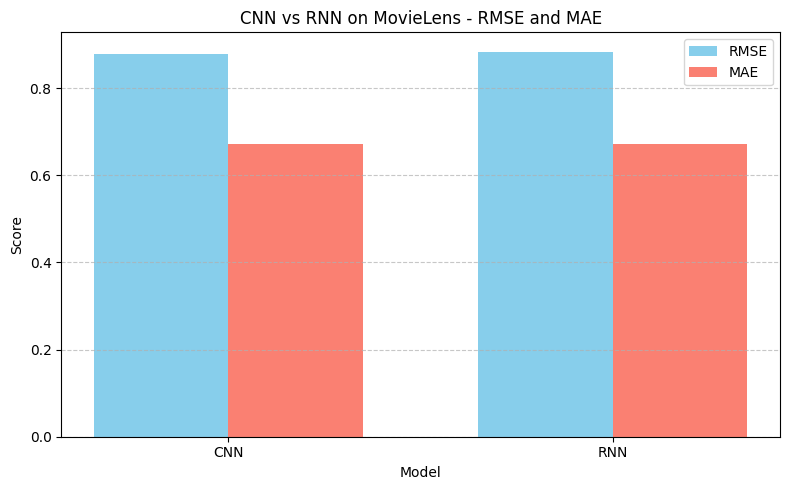

In [19]:
import matplotlib.pyplot as plt

# Metrics
models = ['CNN', 'RNN']
rmse_scores = [0.8796, 0.8841]
mae_scores = [0.6711, 0.6714]

x = range(len(models))

# Plotting
plt.figure(figsize=(8, 5))
bar_width = 0.35

plt.bar(x, rmse_scores, width=bar_width, label='RMSE', color='skyblue')
plt.bar([i + bar_width for i in x], mae_scores, width=bar_width, label='MAE', color='salmon')

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('CNN vs RNN on MovieLens - RMSE and MAE')
plt.xticks([i + bar_width / 2 for i in x], models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
